In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize


In [418]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11]

S0 = 92.3
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0_amd
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [419]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [420]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

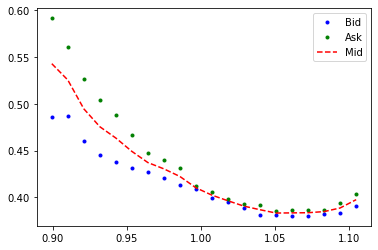

In [421]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/3469634394.py:3: RuntimeWarning: divide by zero encountered in true_divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


     fun: 253.8287107689561
    nfev: 20
     nit: 8
 success: True
       x: 82.26725329153062
82.26725329153062


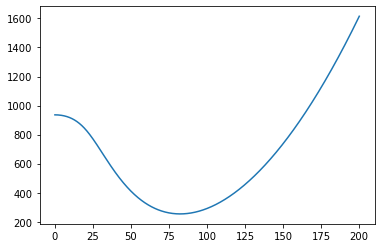

In [422]:
def sigma_objective(sigma, S0):
    sqrtt = math.sqrt(t1)
    help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S_0):
    res = optimize.minimize_scalar(sigma_objective,args = (S_0,))
    print(res)
    return res.x

sigma0 = calculate_sigma0(S0)
xx = np.linspace(0,200,1000)
f = lambda x: sigma_objective(x,S0)
f_ = np.vectorize(f)
plt.plot(xx,f_(xx))
print(sigma_0)


#def m_0(s,S0,sigma0,t1): # Joint distribution of S1 and S2
    #return (S0 >= 0) *  (1/(np.sqrt(2*math.pi)*(sigma0*S0))) * np.exp(-1/2*((s-S0)/(sigma0*S0))**2)  *  (1/(np.sqrt(2*math.pi)*sigma0*S0*np.sqrt(t1)) * np.exp(-1/2*((s-S0)/(sigma0*S0*np.sqrt(t1)))**2) )

def m0(s,S_0,sigma_0,t_1):
    #renormalise m_0 on R^+
    return norm.pdf(s,S_0,sigma_0*np.sqrt(t_1))/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))) if s>=0 else 0


def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g
    




In [423]:
S0+3*sigma0

339.1017598745919

In [424]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*math.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/math.sqrt(2)) - special.erf((A-alpha*sigma)/math.sqrt(2)) )

#def I2(alpha,sigma,s1,K1,K2):
    #A, B = (K1-s1)/sigma, (K2-s1)/sigma
    #return sigma*math.exp(alpha*s1) *  (  2*math.exp(A*alpha*sigma-A*A/2) - math.sqrt(2*math.pi)*alpha*sigma*math.exp((alpha*sigma)**2/2)*special.erf((A-alpha*sigma)/math.sqrt(2)) + math.sqrt(2*math.pi)*alpha*sigma*np.exp((alpha*sigma)**2/2)*special.erf((B-alpha*sigma)/np.sqrt(2)) - 2*math.exp(alpha*B*sigma)-B**2/2  )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*math.exp(alpha*s1) * ( 2*(math.exp(A*alpha*sigma-A*A/2) - math.exp(B*alpha*sigma-B*B/2)) + math.sqrt(2*math.pi)*alpha*sigma*math.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )

#def I2_quad(alpha,sigma,s1,K1,K2):
    ##return 2*math.sqrt(2*math.pi) * integrate.quad(lambda s2: math.exp(alpha*s2)*(s2-s1) * (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-1/2*((s2-s1)/sigma)**2), K1, K2)
    #return integrate.quad(lambda s2: math.exp(alpha*s2)*(s2-s1) * (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-1/2*((s2-s1)/sigma)**2), K1, K2)[0]
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return math.exp(alpha*s1) *  (2*sigma*(math.exp(A*alpha*sigma-A**2/2) - math.exp(B*alpha*sigma-B**2/2))  +   math.sqrt(2*math.pi)*math.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/math.sqrt(2)) - erf((A-alpha*sigma)/math.sqrt(2))) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (math.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + math.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  math.sqrt(2*math.pi)*math.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(math.sqrt(2))) - special.erf((A-alpha*sigma)/(math.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))
    


In [425]:
def I_u_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)

def I_u(theta,V,K,S0,K1,K2,sigma0,t1):
    return integrate.quad(I_u_integrand,K1,K2,args=(theta,V,K,S0,sigma0,t1) )[0]

def I_u_(theta,V,K,S0,K1,K2,sigma0,t1): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma = sigma0*np.sqrt(t1)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*S0)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma,S0,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,S0,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,S0,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI


# Check whether symbolic integration is correct
print(I_u(0,np.zeros(numK),K,S0,0,K[0],sigma0,t1))
for i in range(0,numK-1):
    print(I_u(0,np.zeros(numK),K,S0,K[i],K[i+1],sigma0,t1))
print(I_u(0,np.zeros(numK),K,S0,K[-1],110,sigma0,t1))

print("----")

print(I_u_(0,np.zeros(numK),K,S0,0,110,sigma0,t1))
print(I_u(0,np.zeros(numK),K,S0,0,110,sigma0,t1))


0.23189417511434798
0.024711207977887936
0.026016686496033503
0.02722176343418861
0.028306540260486374
0.029252540638539742
0.030043232272073162
0.03066450677706002
0.031105098149980984
0.03135692250086534
0.03141532474025603
0.03127922170305545
0.03095113556130621
0.03043711608590284
0.029746555104799184
0.02889190110788723
0.02788828611425339
0.026753080423155072
0.025505393536827233
0.02416554124707552
0.1407873715096764
----
0.9183936007554945
0.9183936007556585


In [426]:
def I_h_0_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)*(s-S0)

def I_h_0(theta,V,K,S0,K1,K2,sigma0,t1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,S0,sigma0,t1))[0]

def I_h_0_(theta,V,K,S0,K1,K2,sigma0,t1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma = sigma0*np.sqrt(t1)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,S0,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,S0,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,S0,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI

# Check whether symbolic integration is correct
print(I_h_0(0,np.zeros(numK),K,S0,0,K[0],sigma0,t1))
for i in range(0,numK-1):
    print(I_h_0(0,np.zeros(numK),K,S0,K[i],K[i+1],sigma0,t1))
print(I_h_0(0,np.zeros(numK),K,S0,K[-1],110,sigma0,t1))

print("----")

print(I_h_0_(0,np.zeros(numK),K,S0,0,110,sigma0,t1))
print(I_h_0(0,np.zeros(numK),K,S0,0,110,sigma0,t1))



def I_h_0_grad_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)*(s-S0)*(s-S0)
    
def I_h_0_grad(theta,V,K,S_0,sigma0,t1):
    return integrate.quad(I_h_0_grad_integrand,0,S0+3*sigma0,args=(theta,V,K,S0,sigma0,t1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,S0,sigma0,t1)*(s-S0)*(s-S0)*(s-S0)

def I_h_0_hessian(theta,V,K,S0,sigma0,t1):
    return integrate.quad(I_h_0_hessian_integrand,0,S0+3*sigma0,args=(theta,V,K,S0,sigma0,t1))[0]


-3.872233618827188
-0.21734620096421148
-0.20282523574141822
-0.18501228594141733
-0.16409304877126624
-0.1403395974057791
-0.11410525567106722
-0.08581622581787687
-0.05596022808182871
-0.025072567777474207
0.006279816351738988
0.037515658928093276
0.06805729179355251
0.09734841273727471
0.12487093549423489
0.1501602081003594
0.1728179760709911
0.19252258897252356
0.20903609571929188
0.22220803582426407
1.8662590648912605
----
-1.9157281801156
-1.9157281801159414


In [427]:
def I_Q_integrand(s,h0,V,K,Q,S0,sigma0,t1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m_0(s,S0,sigma0,t1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,S0,K1,K2,sigma0,t1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,S0,sigma0,t1))[0]

def I_Q_(h0,V,K,Q,S0,K1,K2,sigma0,t1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma = sigma0*np.sqrt(t1)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*h0
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(h0*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,S0,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,S0,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == numK-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,S0,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,S0,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return totI

# Check whether symbolic integration is correct
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,K[0],sigma0,t1))
for i in range(0,numK-1):
    print(I_Q(0,np.zeros(numK),K,K[0],S0,K[i],K[i+1],sigma0,t1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,K[-1],110,sigma0,t1))

print("----")


# Check for different Q's
print(I_Q_(0,np.zeros(numK),K,K[0]-10,S0,0,110,sigma0,t1))
print(I_Q(0,np.zeros(numK),K,K[0]-10,S0,0,110,sigma0,t1))

print(I_Q_(0,np.zeros(numK),K,K[0],S0,0,110,sigma0,t1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,110,sigma0,t1))

print(I_Q_(0,np.zeros(numK),K,K[3],S0,0,110,sigma0,t1))
print(I_Q(0,np.zeros(numK),K,K[3],S0,0,110,sigma0,t1))

print(I_Q_(0,np.zeros(numK),K,K[-1],S0,0,110,sigma0,t1))
print(I_Q(0,np.zeros(numK),K,K[-1],S0,0,110,sigma0,t1))

print(I_Q_(0,np.zeros(numK),K,K[-1]+5,S0,0,110,sigma0,t1))
print(I_Q(0,np.zeros(numK),K,K[-1]+5,S0,0,110,sigma0,t1))

0.0
0.012468033230146263
0.03912994867169328
0.06815011399653668
0.09915777565125697
0.13170903053264046
0.1652968044592132
0.19936368720878123
0.2333171847129944
0.2665468114805733
0.29844233643612
0.32841242076650884
0.35590285251370024
0.380413592336171
0.40151389796886716
0.4188548884037106
0.43217903693354753
0.44132623690786565
0.4462362556117851
0.44694756942206637
3.1755816199312505
----
16.164338591971816
16.164338594468763
8.340950097173941
8.340950095702324
6.395552698076312
6.395552698287572
0.5006215612473093
0.5006215612705092
0.05959040871900738
0.05959040817098695


In [428]:
a, b, n = S0-20, S0+20, 11 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid
P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
P1_disc = lambda x: P1(x)/sum(P1(X1))
#sum(P1_disc(X1)) = 1
#sum(X1*P1_disc(X1)) = 92.3 = S0


def integrand_G1(s,V,u0,h0,K,omega,S0,sigma0,t1):
    return m_0(s,S0,sigma0,t1)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size) 

def G1(V,u0,h0,K,omega,S0,sigma0,t1):
    #expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]
    expectation = I_u_(h0,V,K,S0,50,120,sigma0,t1)*np.exp(-u0) # Gives the same result as the other one! -> Confirms P_sig0 = delta(s-S0)
    #print (f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,sigma0,t1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - I_Q_(h0,V,K,Q,S0,50,120,sigma0,t1)*np.exp(-u0) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad


def Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1):
    '''
    Hessian of G_12
    '''
    H = np.zeros((numK,numK))
    H = np.diag(omega)
    
    for i in range(numK):
        for j in range(numK):
            integrand = lambda s: np.maximum((s-K[i]),0)*np.maximum((s-K[j]),0)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size)*m_0(s,S0,sigma0,t1)
            H[i,j] += integrate.quad(integrand,0,S0+3*sigma0)[0] 
    
    return H

    
    

In [429]:
def grad_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    
    grad_FD = np.zeros(numK)
    eps = 1e-7
    for i in range(numK):
        D = np.zeros(numK)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,K,omega,S0,sigma0,t1)-G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
        
    print(f'Grad = {grad}')
    print(f'Grad_FD = {grad_FD}')

u0, h0, V = 0., 0., [0.]*numK
p0 = np.array([u1] + [h1] + V)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

grad_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)




Grad = [-0.73698097 -0.92066888 -1.15472825 -1.36541606 -1.55387884 -1.74613345
 -1.91804952 -2.04533409 -2.15351891 -2.25295071 -2.29378486 -2.28598244
 -2.239311   -2.14834883 -2.02749274 -1.87096896 -1.70284699 -1.5270559
 -1.34740259 -1.16759155]
Grad_FD = [-0.73697092 -0.92065984 -1.15472014 -1.36540881 -1.55387238 -1.74612772
 -1.91804446 -2.04532964 -2.15351501 -2.25294731 -2.29378191 -2.28597989
 -2.23930881 -2.14834697 -2.02749116 -1.87096763 -1.70284588 -1.52705497
 -1.34740182 -1.16759093]


In [430]:
#def Hess_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    #'''
    #Check whether the expression of the Hessian is correct, by comparing it to a finite difference approximation
    #'''
    #Hess = Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    #u = np.ones(numK)
    #eps = 1e-7
    
    #Hess_u = Hess.dot(u)
    #Hess_u_FD = (grad_G1(V+eps*u,u0,h0,K,omega,S0,sigma0,t1)-grad_G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
    
    #print(f'Hess_u = {Hess_u}')
    #print(f'Hess_u_FD = {Hess_u_FD}')
    

#Hess_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)

In [431]:
u0, h0, V = 0., 0., np.array([0.01]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    h0 = optimize.root_scalar(I_h_0_,args=(V,K,S0,50,120,sigma0,t1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    #u1 = -math.log(1/(I_u(h1,V,K,s1,sigma_0,t1)))
    print(f' h0 = {h0}')
    u0 = np.log(I_u_(h0,V,K,S0,50,120,sigma0,t1))
    print(f' u0 = {u0}')



    #V_star = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    print(f'V = {V}')
    
    print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    print("----------")

    
    
    

 h0 = 0.004959776877701127
 u0 = -0.9283647232217996
V = [ 0.16196299 -0.25544776  0.03811016  0.07254678 -0.07059614  0.03612438
  0.1392938  -0.06392704 -0.14598391  0.12465983  0.0972404   0.01297862
  0.02849578  0.0057299   0.08129007  0.02019791  0.04980473  0.08180456
  0.04420996 -0.10601036]
normdiff = 9.990773542149606
----------
 h0 = 0.006065862072573931
 u0 = -0.8479191434085157
V = [ 0.14077535 -0.28811402  0.04562279  0.08972051 -0.06798922  0.05161974
  0.15988498 -0.05247304 -0.15584448  0.15086681  0.09830137  0.01438998
  0.04360199 -0.03115908  0.1202588   0.00984558 -0.00197524  0.002029
  0.32789624 -0.32108859]
normdiff = 0.8342525684833473
----------
 h0 = 0.006551159790564085
 u0 = -0.8055190830680693
V = [ 0.13497105 -0.40800333  0.12775371  0.18829296 -0.10182769  0.05464018
  0.23874888 -0.11833413 -0.28171498  0.2253597   0.12860424 -0.01371806
  0.05289688 -0.03481905  0.16743022 -0.01185491 -0.00713415  0.01485941
  0.30034397 -0.31836461]
normdiff = 0.40

In [432]:
c = np.zeros(numK)
for i in range(numK):
    c[i] = I_Q_(h0,V,K,K[i],S0,50,120,sigma0,t1)*np.exp(-u0)
    print(f'K={K[i]}, C = {c[i]}')

K=83.0, C = 9.574499393926162
K=84.0, C = 8.64824417567345
K=85.0, C = 7.738695935345236
K=86.0, C = 6.853819866297678
K=87.0, C = 6.002833773361657
K=88.0, C = 5.192398232955587
K=89.0, C = 4.4316949506304955
K=90.0, C = 3.7276607287255157
K=91.0, C = 3.0783355850088587
K=92.0, C = 2.486703380474102
K=93.0, C = 1.967494476352711
K=94.0, C = 1.5270997055597744
K=95.0, C = 1.1621847034876016
K=96.0, C = 0.8679313419159921
K=97.0, C = 0.6376871119381436
K=98.0, C = 0.4643333404338047
K=99.0, C = 0.33607492352785245
K=100.0, C = 0.24264125729198685
K=101.0, C = 0.17610516237293497
K=102.0, C = 0.1301350553840424


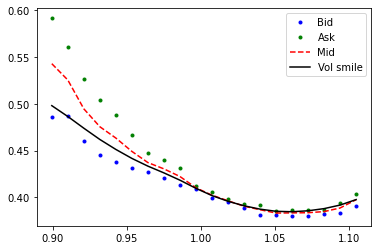

In [433]:
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(c,K,t1,r,S0)), 'k', label='Vol smile')
plt.legend()
plt.show()